# Latents explore (MODIS L2)

In [48]:
# imports
from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns

from ulmo.analysis import io as analy_io
from ulmo.utils import image_utils
from ulmo import plotting
from ulmo import io as ulmo_io

In [30]:
reload(image_utils)

<module 'ulmo.utils.image_utils' from '/tank/xavier/Oceanography/Python/ulmo/ulmo/utils/image_utils.py'>

# Play with a low LL and $\Delta T \sim 2$K

In [12]:
# Load evaluations
evals_tbl = analy_io.load_modis_l2_ll('std', feather=True)

Loading: /data/Projects/Oceanography/AI/OOD/SST/MODIS_L2/Evaluations/R2010_results_std.feather


In [16]:
# Add in DT
if 'DT' not in evals_tbl.keys():
    evals_tbl['DT'] = evals_tbl.T90 - evals_tbl.T10

In [17]:
in_brazil = ((np.abs(evals_tbl.longitude.values + 57.5) < 10.)  & 
    (np.abs(evals_tbl.latitude.values + 43.0) < 10))
in_DT = np.abs(evals_tbl.DT - 2.05) < 0.05
evals_bz = evals_tbl[in_brazil & in_DT].copy()

In [18]:
logL = evals_bz.log_likelihood.values

lowLL_val = np.percentile(logL, 10.)
hiLL_val = np.percentile(logL, 90.)

In [26]:
low = evals_bz.log_likelihood < lowLL_val
high = evals_bz.log_likelihood > hiLL_val

example = evals_bz[low].iloc[-1]
example

index                                             747500
filename            AQUA_MODIS.20190105T045000.L2.SST.nc
row                                                   16
column                                               645
latitude                                        -38.4587
longitude                                       -54.8156
clear_fraction                                0.00604248
mean_temperature                                 18.2167
Tmin                                               16.37
Tmax                                              21.285
T90                                               19.235
T10                                               17.205
log_likelihood                                  -254.305
date                                 2019-01-05 04:50:00
UID                                   154651541312518435
DT                                                  2.03
Name: 12353860, dtype: object

## Show

In [31]:
field, mask = image_utils.grab_modis_l2_img(example, 'PreProc', ptype='std')

<AxesSubplot:>

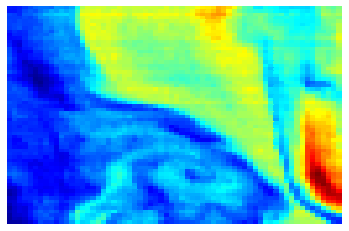

In [35]:
pal, cm = plotting.load_palette()
sns.heatmap(field[0], xticklabels=[], yticklabels=[], cmap=cm,
             cbar=False)

# Load up 2019

In [45]:
pp_file = os.path.join(os.getenv('SST_OOD'), 'MODIS_L2', 
                     'PreProc', 
                     'MODIS_R2019_2019_95clear_128x128_preproc_std.h5')
lat_file = os.path.join(os.getenv('SST_OOD'), 'MODIS_L2', 
                     'Evaluations', 
                     'R2010_on_2019_95clear_128x128_preproc_std_latents.h5')
LL_file = os.path.join(os.getenv('SST_OOD'), 'MODIS_L2', 
                     'Evaluations', 
                     'R2010_on_2019_95clear_128x128_preproc_std_log_prob.h5')

In [39]:
l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

In [40]:
LL_h5 = h5py.File(LL_file, 'r')
LL_h5.keys()

<KeysViewHDF5 ['valid']>

In [52]:
key = 'valid_metadata'
f1 = open(pp_file, 'rb')
with h5py.File(f1, 'r') as f:
    if key in f.keys():
        meta = f[key]
        df = pandas.DataFrame(meta[:].astype(np.unicode_), columns=meta.attrs['columns'])
    else:
        df = pandas.DataFrame()

In [53]:
df.head()

,filename,row,column,latitude,longitude,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10
0,AQUA_MODIS.20190207T021000.L2.SST.nc,1232,837,-29.294142,-11.516745,0.0494384765625,25.6845760345459,22.46500015258789,26.674999237060547,26.084999084472656,25.229999542236328
1,AQUA_MODIS.20190421T000500.L2.SST.nc,1409,550,42.55745,28.580969,0.04864501953125,9.969158172607422,9.4399995803833,10.744999885559082,10.175000190734863,9.769999504089355
2,AQUA_MODIS.20190713T234501.L2.SST.nc,208,229,34.97093,28.369764,0.0,24.64632797241211,22.18000030517578,25.98499870300293,25.39499855041504,23.475000381469727
3,AQUA_MODIS.20190208T205001.L2.SST.nc,208,357,20.297197,71.70419,0.04132080078125,21.573326110839844,18.979999542236328,24.14499855041504,23.28999900817871,20.079999923706055
4,AQUA_MODIS.20190707T161001.L2.SST.nc,773,747,20.832533,145.3258,0.04986572265625,30.616931915283203,27.974998474121094,32.02000045776367,30.94999885559082,30.264999389648438


In [56]:
df['row'] = df.row.astype(int)
df['column'] = df.column.astype(int)

# Find the example

In [60]:
idx_exmple = np.where((df.filename == example.filename) & 
                      (df.row == example.row) & (df.column == example.column))[0][0]
idx_exmple

747500

In [61]:
df.iloc[idx_exmple]

filename            AQUA_MODIS.20190105T045000.L2.SST.nc
row                                                   16
column                                               645
latitude                                      -38.458702
longitude                                     -54.815647
clear_fraction                          0.00604248046875
mean_temperature                      18.216663360595703
Tmin                                  16.369998931884766
Tmax                                   21.28499984741211
T90                                    19.23499870300293
T10                                   17.204999923706055
Name: 747500, dtype: object

# Pull the latent

In [62]:
ilatent = latents[idx_exmple, :]

In [64]:
ilatent.shape

(512,)

# Normalize the latents

In [78]:
norm_latent = np.linalg.norm(latents[:].astype(float), axis=1)
norm_latent.shape

(751689,)

In [82]:
norm_latents = latents / np.outer(norm_latent, np.ones(512))
norm_latents.shape

(751689, 512)

# Dot with the full set

In [89]:
dots = np.dot(norm_latents, norm_latents[idx_exmple, :])
dots.shape

(751689,)

<AxesSubplot:ylabel='Count'>

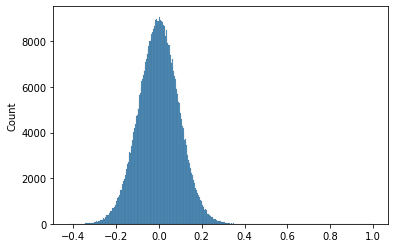

In [91]:
sns.histplot(dots)

In [93]:
isrt = np.argsort(dots)

In [94]:
dots[isrt][-10:]

array([0.42133935, 0.42133935, 0.42189291, 0.42447618, 0.42447618,
       0.43294409, 0.43394279, 0.43436913, 0.44680693, 1.        ])

In [95]:
isrt[-10]

717277

In [99]:
df2 = df.iloc[isrt[-10]]
df2

filename            AQUA_MODIS.20190203T203000.L2.SST.nc
row                                                 1840
column                                               293
latitude                                       11.060091
longitude                                       73.65058
clear_fraction                                  0.015625
mean_temperature                      28.535503387451172
Tmin                                   27.19999885559082
Tmax                                  29.349998474121094
T90                                   28.889999389648438
T10                                    28.14499855041504
Name: 717277, dtype: object

In [97]:
len(df)

751689

In [100]:
i_ex2 = np.where((evals_tbl.filename == df2.filename) & 
            (evals_tbl.row == df2.row) & 
                 (evals_tbl.column == df2.column))[0][0]
i_ex2

12323637

In [101]:
example2 = evals_tbl.iloc[i_ex2]
example2

index                                             717277
filename            AQUA_MODIS.20190203T203000.L2.SST.nc
row                                                 1840
column                                               293
latitude                                         11.0601
longitude                                        73.6506
clear_fraction                                  0.015625
mean_temperature                                 28.5355
Tmin                                                27.2
Tmax                                               29.35
T90                                                28.89
T10                                               28.145
log_likelihood                                   414.626
date                                 2019-02-03 20:30:00
UID                                  1549101060125365058
DT                                              0.745001
Name: 12323637, dtype: object

In [102]:
field2,_ = image_utils.grab_modis_l2_img(example2, 'PreProc', ptype='std')

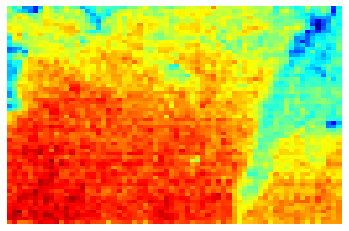

In [104]:
#pal, cm = plotting.load_palette()
_ = sns.heatmap(field2[0], xticklabels=[], yticklabels=[], cmap=cm,
             cbar=False)

# How about another low LL near Brazil?

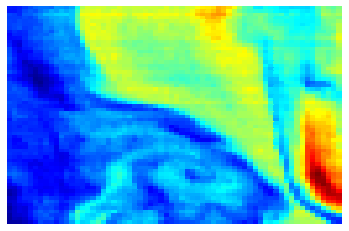

In [111]:
_ = sns.heatmap(field[0], xticklabels=[], yticklabels=[], cmap=cm,
             cbar=False)

In [118]:
example3 = evals_bz[low].iloc[-10]
example3

index                                             687400
filename            AQUA_MODIS.20190801T045001.L2.SST.nc
row                                                  496
column                                               645
latitude                                        -43.1935
longitude                                       -56.2932
clear_fraction                                 0.0394897
mean_temperature                                 7.42656
Tmin                                               5.325
Tmax                                               10.78
T90                                                7.895
T10                                                5.895
log_likelihood                                  -880.574
date                                 2019-08-01 04:50:00
UID                                   156446806512370676
DT                                                     2
Name: 12293760, dtype: object

In [119]:
field3, _ = image_utils.grab_modis_l2_img(example3, 'PreProc', ptype='std')

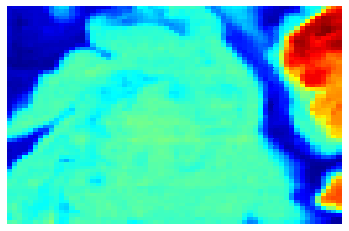

In [120]:
#pal, cm = plotting.load_palette()
_ = sns.heatmap(field3[0], xticklabels=[], yticklabels=[], cmap=cm,
             cbar=False)

## Grab the latent

In [121]:
idx_exmple3 = np.where((df.filename == example3.filename) & 
                      (df.row == example3.row) & (df.column == example3.column))[0][0]
idx_exmple3

687400

In [122]:
dots[idx_exmple], dots[idx_exmple3]

(1.0, -0.08123478283088179)